# Problem Statement:

The objective of this competition is to develop a keypoint regression model capable of predicting the keypoints of a cone in an image. To achieve this goal, participants will be provided with a dataset containing 1000 images of cones and their corresponding keypoint positions (x,y). The challenge involves building a model that can accurately predict the keypoints of cones in unseen images.

### Dataset:

The dataset consists of 1000 images of cones and their corresponding keypoint positions. Each image can be resized to 80x80 pixels, and the dataset preparation class has already been provided to participants. Additionally, data augmentation techniques are available for use to improve the generalization of the model. The keypoint positions are represented as 16-element vectors for each image.

### Model:

Participants are free to use any approach or model architecture to prepare their model. However, it should be capable of predicting the keypoint positions accurately. The models will be evaluated based on the following criteria:

    1) MSELoss: The model should have a low mean squared error (MSE) when predicting the keypoint positions. The lower the MSE, the better the model.

    2) Visual Display: The model's output should be visually appealing, accurately displaying the predicted keypoints on the cones. A good visual display of the output keypoints will indicate the quality of the model.

### Judging Criteria:

The models submitted by participants will be evaluated based on the following criteria:

    1) MSELoss: The models with lower MSE will be awarded higher scores. The MSE will be calculated based on the predicted keypoint positions of the cones.

    2) Visual Display: The models will be evaluated based on the visual display of the predicted keypoints on the cones. The models with better visual displays will be awarded higher scores.

    3) Inference Time: The inference time of each model will be measured based on 100 iterations. The models with shorter inference times will be awarded higher scores.

The model with the highest score based on the above criteria will be declared the winner of the competition.

### Examples:
keypoint_regression/notebooks/Training.ipynb

### NOTE!!
You do not require the complete code base, as the other files are only included for reference purposes. These files can help you understand the overall pipeline bigger picture.

In [1]:
import sys
import os

sys.path.append("..")

import torch

from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.nn import Module, MSELoss, L1Loss

import torchvision.transforms as transforms

from dataset import  KeypointDataset

from model import KeypointNet

from trainer import TrainingParameters, train

from utils import *

In [2]:
imgsPath = "../data/imgs"
jsonPath = "../data/json"

dataset = KeypointDataset(jsonPath, imgsPath,0,0,0)

In [3]:
# preparing dataloaders
TRAIN_SIZE = int(0.7*len(dataset))
VALID_SIZE = int(0.2*len(dataset))
TEST_SIZE = len(dataset) - TRAIN_SIZE - VALID_SIZE
BATCH_SIZE = 128

# random split the data
trainDataset, valDataset, testDataset = random_split(dataset, [TRAIN_SIZE, VALID_SIZE, TEST_SIZE])

# creating dataloaders
trainLoader = DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True)
validLoader = DataLoader(valDataset, batch_size=BATCH_SIZE, shuffle=True)
testLoader = DataLoader(testDataset, batch_size=BATCH_SIZE, shuffle=True)

# sanity check
print('='*30)
print("Train dataset", len(trainDataset))
print("Valid dataset", len(valDataset))
print("Test dataset", len(testDataset))

Train dataset 865
Valid dataset 247
Test dataset 125


### Example of how to show image from batch

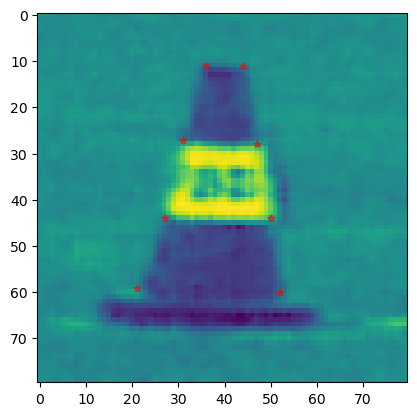

In [4]:
# sanity check
import numpy as np

imgs, labels = next(iter(testLoader))
i = 0
bs, _, height, width = imgs.shape
kps = labels[i].cpu().detach().numpy()

kps = kps.reshape(-1,2)
kps[:,0] = kps[:,0]*width
kps[:,1] = kps[:,1]*height
kps = kps.astype(int)

img = imgs[i].cpu().detach().permute(1,2,0).squeeze(2).numpy().astype(np.float32).copy()
for point1 in kps:
    plt.plot(*point1, marker='*', color='red', alpha=0.5)

plt.imshow(img)
plt.show()

## Modelling 

In [ ]:
class KeypointNet(Module):
    def __init__(self, inputChannels, outKeypoints):
        super().__init__()
        self.inputChannels = inputChannels
        self.outKeypoints = outKeypoints
        # @TODO Define your model
        
    #@TODO write the forward function
    def forward(self, x):
        pass

## Training

In [ ]:
model = KeypointNet(inputChannels=1, outKeypoints=8)
optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=25, verbose=True)
trainingTracker = []
validTracker = []

trainingParameters = TrainingParameters(
    model=model,
    criterion=CombinedLoss(0.1),
    optimizer=optimizer,
    trainloader=trainLoader,
    validloader=validLoader,
    epochs=2000,
    savedModelName= "checkpoints/model.pth",
    scheduler=scheduler,
    trainingTracker=trainingTracker,
    validTracker=validTracker
)

In [ ]:
train(trainingParameters) # starts the model training

## Metrics Visualization and Testing

In [ ]:
# Training and validation plots
START = ... # @TODO start count to show (0 or more at your convenience) 
LIMIT = ... # @TODO put your stop epoch

epochs = np.arange(LIMIT-START)
plt.plot(epochs, trainingTracker[START:LIMIT], label="Training")
plt.plot(epochs, validTracker[START:LIMIT], label="Validation")
plt.legend()
plt.show()

In [ ]:
# test loss
model = KeypointNet(inputChannels=1, outKeypoints=8)
model.load_state_dict(torch.load("checkpoints/mseloss2.pth"))
model = model.cuda()
testloss = 0
criterion = CombinedLoss()

with torch.no_grad():
    model.eval()
    for imgs, labels in testLoader:
        batchSize, *_ =imgs.shape
        out = model(imgs.cuda())
        loss = criterion(out, labels.cuda())
        testloss+=loss.item()*batchSize
        
print("Loss:", testloss/len(testLoader.dataset))

## Show model output visualized (images)

In [ ]:
import matplotlib.pyplot as plt

imgs, labels = next(iter(testLoader))

for j, (imgs, labels) in enumerate(testLoader):
    with torch.no_grad():
        model.eval()
        model = model.cuda()
        outs = model(imgs.cuda())

    bs, _, height, width = imgs.shape
    fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(20,20))

    for i, axi in enumerate(ax.flat):
        # get keypoints
        try:
            kps = outs[i].cpu().detach().numpy()
            kps = kps.reshape(-1,2)
            kps[:,0] = kps[:,0]*width
            kps[:,1] = kps[:,1]*height
            kps = kps.astype(int)
            # labels
            label = labels[i].cpu().detach().numpy()
            label = label.reshape(-1,2)
            label[:,0] = label[:,0]*width
            label[:,1] = label[:,1]*height
            label = label.astype(int)
            # get img
            img = imgs[i].cpu().detach().permute(1,2,0).squeeze(2).numpy().astype(np.float32).copy()

            for point1, point2 in zip(kps, label):
                axi.plot(*point1, marker='.', color='red', alpha=0.5)
                axi.plot(*point2, marker='*', color='blue', alpha=0.5)
            axi.imshow(img)
        except: 
            continue

    fig.show()
    fig.savefig(f"res_{j}"".png")